### OCI Data Science - Useful Tips
Everything stored in the <span style="background-color: #d5d8dc ">/home/datascience</span> folder is now stored on your block volume drive. The <span style="background-color: #d5d8dc ">ads-examples</span> folder has moved outside of your working space. Notebook examples are now accessible through a Launcher tab "Notebook Examples" button.
<details>
<summary><font size="2">1. Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">2. OCI Configuration and Key Files Set Up</font></summary><p>Follow the instructions in the getting-started notebook. That notebook is accessible via the "Getting Started" Launcher tab button.</p>
</details>
<details>
<summary><font size="2">3. Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">4. Typical Cell Imports and Settings</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">5. Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install pycaret

# EDA

The business is currently operated by the Tony and Mary Trumpo, 9 full time panel beating and mechanical professionals and 3 casual office assistants. The expected turnover for a business of this size is $2.1M, instead it is operating with a turnover of 14.3M. Where is the additional 12.2M coming from?

Mary’s brother has a drug distribution network which has a need to move funds approximating $1M a month. The transaction history and account information were able to ascertained for analysis and some initial work on where the money is going has been done. Below is the type of information that able to be accessed.

In [54]:
path = 'https://objectstorage.ap-melbourne-1.oraclecloud.com/p/9SlQmk6Qk2n3MC5c0G7MKn7jEm81t5TXOMUcCkLFiaJIOArN9VUvbQLo8gigV0rm/n/axqqyh9cozw7/b/digitaldefence-bucket001/o/datasetsfaccount.txt'
account = pd.read_csv(path, index_col=0)
account['ACCTTYPE'] = pd.Categorical(account['ACCTTYPE'], categories=['BUSINESS', 'CREDIT', 'MAXI-SAVER', 'SAVINGS'], ordered=False)
account[['DOB', 'ACCTCREATED']] = pd.to_datetime(account[['DOB', 'ACCTCREATED']].stack(), format='%Y-%m-%dT%H:%M:%S').unstack()
account['ACCTRISK'] = pd.Categorical(account['ACCTRISK'], categories=['LOW', 'MEDIUM', 'HIGH'], ordered=True)
cat_arr = ['Supermarket', 'Grocery', 'Cafe', 'Bakery', 'Hotel', 'Restaurant',
       'Builders', 'Lawyers', 'Crash Repairs', 'Apparel', 'Smallgoods',
       'Property', 'Cleaning', 'Gardening', 'Electrical', 'Wholesale',
       'Events', 'Computers', 'Clinic', 'Winery', 'Roasters', 'Pottery',
       'Therapeutics', 'Fitness', 'Physiotherapy', 'Beauty', 'Podiatry',
       'Florist', 'Finance', 'Sports', 'Brewery', 'Used Cars', 'Garage',
       'Pharmacy', 'Butcher', 'Consulting', 'Distillery', 'Cheeses',
       'Management', 'Services', 'Childcare', 'Digital', 'Accounting',
       'Salamis', 'Trading', 'Music', 'CUSTOMER']

account['CATEGORY'] = pd.Categorical(account['CATEGORY'], categories=cat_arr)

In [55]:
account.head()

,ACCTTYPE,ACCTNAME,FIRSTNAME,SURNAME,DOB,ACCTCREATED,ACCTRISK,ADDRESS,ADDRESS_LAT,ADDRESS_LON,CATEGORY
ACCTID,,,,,,,,,,,
800039,BUSINESS,Young Supermarket,Kevin,Young,1982-02-23,2018-09-20,MEDIUM,BRISBANE,-27.512179,153.073105,Supermarket
800040,BUSINESS,Williams Grocery,Lindsay,Williams,1959-02-20,2018-02-24,MEDIUM,BRISBANE,-27.504303,153.073470,Grocery
800041,CREDIT,Myers Supermarket,Lisa,Myers,1982-09-04,2018-01-11,HIGH,BRISBANE,-27.484970,153.097588,Supermarket
800042,BUSINESS,Martinez Supermarket,Brittany,Martinez,1976-10-11,2018-12-04,MEDIUM,BRISBANE,-27.402357,153.056983,Supermarket
800043,CREDIT,Taylor Grocery,David,Taylor,1978-01-23,2019-07-15,MEDIUM,BRISBANE,-27.473628,152.955089,Grocery


In [56]:
path = 'https://objectstorage.ap-melbourne-1.oraclecloud.com/p/F8fm0TUmThBg2ebXZoSInUJPDZv3-MKv_14c2RraIXHzpgBR-gnxGXDUygNsomE3/n/axqqyh9cozw7/b/digitaldefence-bucket001/o/datasetsftxn2.txt'

In [57]:
col_types = {"id": np.int32}
usecolslist = ['TXN_ID', 'TXTYPE', 'AMOUNT', 'FROMACCTID', 'TOACCTID','TXDATE', 'REFERENCE']
dtypes_dict = {
    'TXTYPE': 'category',
    'REFERENCE': 'category',
    'AMOUNT': np.int32,
    'FROMACCTID': np.int32,
    'TOACCTID': np.int32
}

transaction = pd.read_csv(path, 
                          parse_dates=['TXDATE'], 
                          infer_datetime_format=True, 
                          index_col=0, 
                          usecols=usecolslist,
                         dtype=dtypes_dict)
transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1533066 entries, 950060711303 to 950134025903
Data columns (total 6 columns):
TXTYPE        1533066 non-null category
AMOUNT        1533066 non-null int32
FROMACCTID    1533066 non-null int32
TOACCTID      1533066 non-null int32
TXDATE        1533066 non-null datetime64[ns]
REFERENCE     1533066 non-null category
dtypes: category(2), datetime64[ns](1), int32(3)
memory usage: 45.4 MB


In [58]:
transaction.head()

,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,TXDATE,REFERENCE
TXN_ID,,,,,,
950060711303,PAYMENT,320,500607,800242,2020-01-22 17:00:00,Dinner with Shane
950060711401,PAYMENT,48,500607,800111,2020-01-23 08:00:00,Breakfast with Steven
950060711402,TRANSFER,6209,500607,500929,2020-01-23 13:00:00,Holiday Cost
950060711403,PAYMENT,66,500607,800252,2020-01-23 17:00:00,Meal with Mary
950060711501,PAYMENT,47,500607,800116,2020-01-24 08:00:00,Coffee with Brian


In [59]:
transaction['REFERENCE'].value_counts()

Holiday Cost               64142
Subscription Costs         64097
Paid for FixUp             64054
Water Costs                63974
Payment for Job            63858
Gift Costs                 63767
Instalment                 63674
Settling Deal              63500
Meal with Michael           5865
Breakfast with Michael      5821
Coffee with Michael         5788
Dinner with Michael         5787
Meal with David             4074
Coffee with David           4052
Breakfast with David        3997
Dinner with David           3937
Meal with James             3853
Coffee with Jennifer        3813
Coffee with John            3796
Meal with John              3792
Breakfast with James        3780
Dinner with James           3766
Breakfast with Jennifer     3742
Coffee with James           3739
Meal with Christopher       3697
Dinner with Jennifer        3697
Breakfast with John         3691
Dinner with John            3666
Meal with Jennifer          3652
Coffee with Christopher     3629
          

In [60]:
transaction['AMOUNT'].describe()

count    1.533066e+06
mean     1.865467e+03
std      3.039119e+03
min      2.500000e+01
25%      6.600000e+01
50%      2.800000e+02
75%      2.873000e+03
max      2.000200e+05
Name: AMOUNT, dtype: float64

In [61]:
transaction.head()

,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,TXDATE,REFERENCE
TXN_ID,,,,,,
950060711303,PAYMENT,320,500607,800242,2020-01-22 17:00:00,Dinner with Shane
950060711401,PAYMENT,48,500607,800111,2020-01-23 08:00:00,Breakfast with Steven
950060711402,TRANSFER,6209,500607,500929,2020-01-23 13:00:00,Holiday Cost
950060711403,PAYMENT,66,500607,800252,2020-01-23 17:00:00,Meal with Mary
950060711501,PAYMENT,47,500607,800116,2020-01-24 08:00:00,Coffee with Brian


# Clustering

In [62]:
account.head()

,ACCTTYPE,ACCTNAME,FIRSTNAME,SURNAME,DOB,ACCTCREATED,ACCTRISK,ADDRESS,ADDRESS_LAT,ADDRESS_LON,CATEGORY
ACCTID,,,,,,,,,,,
800039,BUSINESS,Young Supermarket,Kevin,Young,1982-02-23,2018-09-20,MEDIUM,BRISBANE,-27.512179,153.073105,Supermarket
800040,BUSINESS,Williams Grocery,Lindsay,Williams,1959-02-20,2018-02-24,MEDIUM,BRISBANE,-27.504303,153.073470,Grocery
800041,CREDIT,Myers Supermarket,Lisa,Myers,1982-09-04,2018-01-11,HIGH,BRISBANE,-27.484970,153.097588,Supermarket
800042,BUSINESS,Martinez Supermarket,Brittany,Martinez,1976-10-11,2018-12-04,MEDIUM,BRISBANE,-27.402357,153.056983,Supermarket
800043,CREDIT,Taylor Grocery,David,Taylor,1978-01-23,2019-07-15,MEDIUM,BRISBANE,-27.473628,152.955089,Grocery


In [63]:
merged = pd.concat([transaction.set_index('FROMACCTID'), account], axis=1, join='inner').reset_index()
#merged = merged.drop(['index', 'TOACCTID', 'ACCTNAME', 'FIRSTNAME', 'SURNAME', 'DOB', 'ACCTCREATED', 'ADDRESS'], axis=1)

In [64]:
merged.head()

,index,TXTYPE,AMOUNT,TOACCTID,TXDATE,REFERENCE,ACCTTYPE,ACCTNAME,FIRSTNAME,SURNAME,DOB,ACCTCREATED,ACCTRISK,ADDRESS,ADDRESS_LAT,ADDRESS_LON,CATEGORY
0,500607,PAYMENT,320,800242,2020-01-22 17:00:00,Dinner with Shane,MAXI-SAVER,"Smith, Elizabeth",Elizabeth,Smith,1961-11-25,2018-10-30,LOW,BRISBANE,-27.42151,153.049456,CUSTOMER
1,500607,PAYMENT,48,800111,2020-01-23 08:00:00,Breakfast with Steven,MAXI-SAVER,"Smith, Elizabeth",Elizabeth,Smith,1961-11-25,2018-10-30,LOW,BRISBANE,-27.42151,153.049456,CUSTOMER
2,500607,TRANSFER,6209,500929,2020-01-23 13:00:00,Holiday Cost,MAXI-SAVER,"Smith, Elizabeth",Elizabeth,Smith,1961-11-25,2018-10-30,LOW,BRISBANE,-27.42151,153.049456,CUSTOMER
3,500607,PAYMENT,66,800252,2020-01-23 17:00:00,Meal with Mary,MAXI-SAVER,"Smith, Elizabeth",Elizabeth,Smith,1961-11-25,2018-10-30,LOW,BRISBANE,-27.42151,153.049456,CUSTOMER
4,500607,PAYMENT,47,800116,2020-01-24 08:00:00,Coffee with Brian,MAXI-SAVER,"Smith, Elizabeth",Elizabeth,Smith,1961-11-25,2018-10-30,LOW,BRISBANE,-27.42151,153.049456,CUSTOMER


In [48]:
train = merged.sample(150000).reset_index().drop(['index'], axis=1)

In [49]:
train.head()

,TXTYPE,AMOUNT,TXDATE,REFERENCE,ACCTTYPE,ACCTRISK,ADDRESS_LAT,ADDRESS_LON,CATEGORY
0,PAYMENT,377,2019-11-28 17:00:00,Dinner with Don,CREDIT,LOW,-27.460564,153.097593,CUSTOMER
1,PAYMENT,26,2019-11-03 08:00:00,Breakfast with Stephen,CREDIT,LOW,-27.516648,153.038996,CUSTOMER
2,PAYMENT,72,2020-06-24 08:00:00,Coffee with Thomas,MAXI-SAVER,MEDIUM,-27.476652,152.986058,CUSTOMER
3,TRANSFER,3069,2019-12-28 13:00:00,Paid for FixUp,CREDIT,HIGH,-27.455051,153.067686,CUSTOMER
4,PAYMENT,228,2020-05-13 17:00:00,Dinner with James,BUSINESS,LOW,-27.438901,152.977983,CUSTOMER


In [50]:
import pycaret

In [51]:
#import clustering module
from pycaret.clustering import *
#intialize the setup
exp_clu = setup(train,
               normalize=True)

,Description,Value
0,session_id,2027
1,Original Data,"(150000, 9)"
2,Missing Values,False
3,Numeric Features,3
4,Categorical Features,5
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(150000, 2801)"
9,CPU Jobs,-1


In [52]:
# create k-means model
kmeans = create_model('kmeans')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1062,19881.5821,2.2398,0,0,0


# API Connectivity

In [33]:
import requests

In [ ]:
r = requests.post(url = API_ENDPOINT, data = msg) 
# extracting response text  
pastebin_url = r.text 
print("The pastebin URL is: %s" % pastebin_url) 

In [34]:
API_ENDPOINT = ''
response = requests.get("http://api.open-notify.org/this-api-doesnt-exist")

In [71]:
merged.head()

,index,TXTYPE,AMOUNT,TOACCTID,TXDATE,REFERENCE,ACCTTYPE,ACCTNAME,FIRSTNAME,SURNAME,DOB,ACCTCREATED,ACCTRISK,ADDRESS,ADDRESS_LAT,ADDRESS_LON,CATEGORY,NAME
0,500607,PAYMENT,320,800242,2020-01-22 17:00:00,Dinner with Shane,MAXI-SAVER,"Smith, Elizabeth",Elizabeth,Smith,1961-11-25,2018-10-30,LOW,BRISBANE,-27.42151,153.049456,CUSTOMER,Elizabeth Smith
1,500607,PAYMENT,48,800111,2020-01-23 08:00:00,Breakfast with Steven,MAXI-SAVER,"Smith, Elizabeth",Elizabeth,Smith,1961-11-25,2018-10-30,LOW,BRISBANE,-27.42151,153.049456,CUSTOMER,Elizabeth Smith
2,500607,TRANSFER,6209,500929,2020-01-23 13:00:00,Holiday Cost,MAXI-SAVER,"Smith, Elizabeth",Elizabeth,Smith,1961-11-25,2018-10-30,LOW,BRISBANE,-27.42151,153.049456,CUSTOMER,Elizabeth Smith
3,500607,PAYMENT,66,800252,2020-01-23 17:00:00,Meal with Mary,MAXI-SAVER,"Smith, Elizabeth",Elizabeth,Smith,1961-11-25,2018-10-30,LOW,BRISBANE,-27.42151,153.049456,CUSTOMER,Elizabeth Smith
4,500607,PAYMENT,47,800116,2020-01-24 08:00:00,Coffee with Brian,MAXI-SAVER,"Smith, Elizabeth",Elizabeth,Smith,1961-11-25,2018-10-30,LOW,BRISBANE,-27.42151,153.049456,CUSTOMER,Elizabeth Smith


In [72]:
account["NAME"] = account["FIRSTNAME"] + " " + account["SURNAME"]

In [73]:
account

,ACCTTYPE,ACCTNAME,FIRSTNAME,SURNAME,DOB,ACCTCREATED,ACCTRISK,ADDRESS,ADDRESS_LAT,ADDRESS_LON,CATEGORY,NAME
ACCTID,,,,,,,,,,,,
800039,BUSINESS,Young Supermarket,Kevin,Young,1982-02-23,2018-09-20,MEDIUM,BRISBANE,-27.512179,153.073105,Supermarket,Kevin Young
800040,BUSINESS,Williams Grocery,Lindsay,Williams,1959-02-20,2018-02-24,MEDIUM,BRISBANE,-27.504303,153.073470,Grocery,Lindsay Williams
800041,CREDIT,Myers Supermarket,Lisa,Myers,1982-09-04,2018-01-11,HIGH,BRISBANE,-27.484970,153.097588,Supermarket,Lisa Myers
800042,BUSINESS,Martinez Supermarket,Brittany,Martinez,1976-10-11,2018-12-04,MEDIUM,BRISBANE,-27.402357,153.056983,Supermarket,Brittany Martinez
800043,CREDIT,Taylor Grocery,David,Taylor,1978-01-23,2019-07-15,MEDIUM,BRISBANE,-27.473628,152.955089,Grocery,David Taylor
800044,CREDIT,Orr Grocery,Adrian,Orr,1968-09-04,2016-12-11,LOW,BRISBANE,-27.462055,153.007911,Grocery,Adrian Orr
800045,CREDIT,Anderson Grocery,Raymond,Anderson,1980-03-21,2018-02-12,LOW,BRISBANE,-27.402610,153.003706,Grocery,Raymond Anderson
800046,CREDIT,Berg Grocery,Jennifer,Berg,1986-07-06,2018-05-30,LOW,BRISBANE,-27.449499,153.014107,Grocery,Jennifer Berg
800047,CREDIT,Hatfield Supermarket,Jocelyn,Hatfield,1986-06-06,2019-01-06,MEDIUM,BRISBANE,-27.535465,153.068066,Supermarket,Jocelyn Hatfield


In [74]:
temp = account.groupby("NAME")["ACCTNAME"].count()

In [79]:
multiple_acct = temp[temp==2]

In [84]:
i = multiple_acct.index

In [92]:
short_df = account[account["NAME"].isin(i)]

In [94]:
id_mul = short_df.index

In [95]:
id_mul

Int64Index([800060, 800104, 800105, 800132, 800208, 800473, 800479, 800297,
            800354, 800359, 800369, 800371, 800383, 800435, 800440, 800442,
            800545, 800553, 800565, 500189, 500012, 500112, 500433, 500446,
            500451, 500518, 500527, 500252, 500280, 500672, 500698, 500384,
            500803, 500818, 500903, 500542, 500586, 501047, 501063, 501083,
            501103, 501123, 501139, 500838, 500854, 500931, 500956, 501260,
            501265, 501364, 501390, 501187, 501193, 501204],
           dtype='int64', name='ACCTID')

In [96]:
transaction.head()

,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,TXDATE,REFERENCE
TXN_ID,,,,,,
950060711303,PAYMENT,320,500607,800242,2020-01-22 17:00:00,Dinner with Shane
950060711401,PAYMENT,48,500607,800111,2020-01-23 08:00:00,Breakfast with Steven
950060711402,TRANSFER,6209,500607,500929,2020-01-23 13:00:00,Holiday Cost
950060711403,PAYMENT,66,500607,800252,2020-01-23 17:00:00,Meal with Mary
950060711501,PAYMENT,47,500607,800116,2020-01-24 08:00:00,Coffee with Brian


In [99]:
detail = transaction[(transaction["FROMACCTID"].isin(id_mul)) | (transaction["TOACCTID"].isin(id_mul)) ]

In [100]:
detail.describe()

,AMOUNT,FROMACCTID,TOACCTID
count,75746.000000,75746.000000,75746.000000
mean,1855.804914,500760.949436,700527.755419
std,3208.735112,2213.244157,141103.548968
min,25.000000,500000.000000,500000.000000
25%,63.000000,500433.000000,501103.000000
50%,253.000000,500803.000000,800121.000000
75%,2862.750000,501102.000000,800208.000000
max,200019.000000,800435.000000,800435.000000


In [105]:
import seaborn as sns

In [104]:
!pip install --upgrade seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.0)


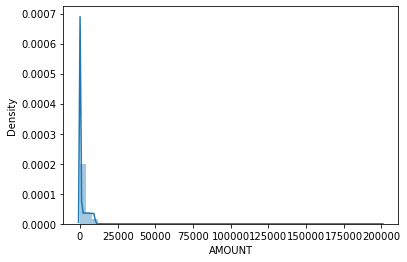

In [106]:
sns.distplot(detail["AMOUNT"])

In [110]:
detail["AMOUNT"].max()

200019

In [113]:
detail[detail["AMOUNT"] == 200019]

,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,TXDATE,REFERENCE
TXN_ID,,,,,,
9150080115012,TRANSFER,200019,800434,800435,2020-02-28 10:00:00,Holiday Cost


In [147]:
detail[detail["TOACCTID"] == 800373]

,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,TXDATE,REFERENCE
TXN_ID,,,,,,


In [115]:
detail[detail["TOACCTID"] == 800435]

,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,TXDATE,REFERENCE
TXN_ID,,,,,,
9150080015012,TRANSFER,200003,800434,800435,2020-02-28 10:00:00,Holiday Cost
9150080115012,TRANSFER,200019,800434,800435,2020-02-28 10:00:00,Holiday Cost


In [126]:
detail[detail["FROMACCTID"] == 800435]

,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,TXDATE,REFERENCE
TXN_ID,,,,,,
9150080015050,TRANSFER,200012,800435,500800,2020-02-28 11:00:00,Holiday Cost
9150080115050,TRANSFER,200018,800435,500801,2020-02-28 11:00:00,Holiday Cost


In [136]:
detail[detail["FROMACCTID"] == 800377]

,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,TXDATE,REFERENCE
TXN_ID,,,,,,


In [132]:
s = transaction[transaction["TXTYPE"] == "TRANSFER"]

In [145]:
s[s["AMOUNT"]>200000]

,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,TXDATE,REFERENCE
TXN_ID,,,,,,
9150080015099,TRANSFER,200002,500800,800377,2020-02-28 09:00:00,Payment for Job
9150080015000,TRANSFER,200013,800377,800378,2020-02-28 10:00:00,Instalment
9150080015001,TRANSFER,200006,800378,800379,2020-02-28 10:00:00,Settling Deal
9150080015002,TRANSFER,200012,800379,800381,2020-02-28 10:00:00,Instalment
9150080015003,TRANSFER,200004,800381,800382,2020-02-28 10:00:00,Gift Costs
9150080015004,TRANSFER,200008,800382,800388,2020-02-28 10:00:00,Paid for FixUp
9150080015005,TRANSFER,200008,800388,800390,2020-02-28 10:00:00,Payment for Job
9150080015006,TRANSFER,200011,800390,800392,2020-02-28 10:00:00,Water Costs
9150080015007,TRANSFER,200014,800392,800403,2020-02-28 10:00:00,Settling Deal


In [144]:
y = account[account.isin([800434])]
y.dropna()

,ACCTTYPE,ACCTNAME,FIRSTNAME,SURNAME,DOB,ACCTCREATED,ACCTRISK,ADDRESS,ADDRESS_LAT,ADDRESS_LON,CATEGORY,NAME
ACCTID,,,,,,,,,,,,


In [152]:
transaction["TXTYPE"].value_counts()

PAYMENT     1022000
TRANSFER     511066
Name: TXTYPE, dtype: int64

In [ ]:
transaction[transaction["TXTYPE"] == "TRANSFER"]["AMOUNT"].sum()

In [ ]:
transaction[transaction["TXTYPE"] == "TRANSFER"]["AMOUNT"].sum()